# Analyzing Play Time Contribution by Different Player Types

## Introduction

PLAI, an AI research group within the Faculty of Computer Science at UBC, has set up a Minecraft server to develop an AI that surpasses current technological constraints. Through this server, the researchers have gathered data on participants' in-game actions and communication, with the goal of collecting over 10,000 hours of data to create a complex AI that replicates player-like behaviour within the virtual world, or similarly, an AGI (Artificial General Intelligence)-like agent. However, to gather more significant data, PLAI researchers aim to identify which players, or player types, contribute the most hours of gameplay. Therefore, this analysis will address the following question: Can we determine which players are most likely to contribute the most hours of gameplay based on their age and experience with the game?

To answer the question, this project uses two datasets containing player information and session details: ```players.csv``` and ```sessions.csv```.

*[ ] indicates variable data type

---

```players.csv```: A dataset containing identifying information provided during recruitment for all participants, including their total playtime. It contains 196 **observations** and 9 **variables**.

- ```experience```: Participant's self-reported Minecraft experience level [Character/Categorical] - (Amateur, Beginner, Regular, Pro, Veteran).
- ```subscribe```: Whether the participant is subscribed to PLAI emails [Character].
- ```hashedEmail```: The participant's provided email address, encrypted for privacy [Character]. 
- ```played_hours```: Total number of hours the participant has played on the server [Double].
- ```name```: The participant's provided name [Character].
- ```gender```: The participant's identified gender [Character].
- ```age```: The participant's age [Double].
- ```IndividualID```: The participant's ID; another means of identification [Logical].*
- ```organizationName```: The participant's affiliated organization [Logical].*

*Note: **IndividualID** and **organizationName** are labelled as NA and are not provided in the dataset.

---


```sessions.csv```: A dataset containing each play session per individual, including their start and end times. It contains 1535 **observations** and 5 **variables**. 

- ```hashedEmail```: The participant's provided email address, encrypted for privacy [Character].
- ```start_time```: Session start date (dd/mm/yyyy) and time (24hr) [Character].
- ```end_time```: Session end date (dd/mm/yyyy) and time (24hr) [Character].
- ```original_start_time```: Session start time in UNIX timestamp - seconds since Jan 1st, 1970 (UTC) [Double].
- ```original_end_time```: Session end time in UNIX timestamp - seconds since Jan 1st, 1970 (UTC) [Double].

---

## Methods & Results

We will use **KNN-Classification** with `age` and `played_hours` as predictor variables, identifying the types of players that have the highest playtime. To address the question, we will use the categorical variable, `experience`, to classify players as **Amateurs**, **Beginners**, **Regulars**, **Pros**, or **Veterans**.

---
### Loading the packages into R

To begin the analysis, we loaded the following **packages**:
1. ```tidyverse``` - Contains most of the basic functions needed for analysis (ex. data wrangling)

2. ```RColorBrewer``` - Introduces additional color palettes for visualization, which is important for addressing colorblindness. 

3. ```tidymodels``` - Provides functions necessary to train and create the KNN-classification model. 

4. ```repr``` - Contains functions to control how R objects are displayed (ex. Reformatting visualizations)

5. ```themis``` - Includes the ```step_upsample``` function needed for balancing the ```experience``` class. 

The ```options``` function, used with the ```matrix``` argument, controls the number of rows displayed per data frame. We specify that 5 rows should be displayed. 


In [1]:
#Contains most functions needed for analysis
library(tidyverse) 

#To obtain colors for visualization: Colorblind-friendly Palettes
library(RColorBrewer) 


#Contains the functions to create a model
library(tidymodels)

#Controls how R objects are displayed. Enhances the details of outputs by indirectly formatting how they appear (ex. options). 
library(repr)

#To balance the experience classes
library(themis)

#To obtain a maximum of 5 rows per data frame
options(repr.matrix.max.rows = 5) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading the datasets into R

Next, we loaded both ```players.csv``` and ```sessions.csv``` into the analysis using the ```read_csv``` function and their respective URLs. 

The data frames were assigned to their respective names: ***players*** and ***sessions***.

In [2]:
#Loading both datasets (players and session data) into the datafile. 
players <- read_csv ("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

sessions <- read_csv ("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling
In this section, we wrangled the data into a usable, tidy format. From this, we created a data frame containing only the variables of interest: ```experience```, ```played_hours```, and ```age```.

1. First, we use the ```set.seed``` function to set a **seed** with a value of **100**. This ensures that functions requiring randomness will produce the same results when the same code is run in other instances.

2. Using the ```merge``` function, both **players** and **sessions** were combined based on matching ```hashedEmail``` variable values. Separate instances (ex. different ```start_time``` and ```end_time``` values were treated as separate observations. 

3. The merged dataset was further refined using the ```select``` function to create a data frame containing only the variables of interest.

4. Finally, values equal to 0 were removed from the ```played_hours``` variable using the ```filter``` function, as they are not meaningful to the analysis. Moreover, to create a visualization, we would need to scale the y-axis to spread the points out, preventing increased overplotting. This would result in values of 0 becoming infinity, which is problematic considering we are using KNN-classification (ex. KNN-classification could consider these values as hours > 0, when in reality, they are 0).

5. The ```head``` and ```tail```functions were used to display the first and last 6 rows of the wrangled dataset (**playdate_NA**)

In [3]:
#Setting the seed. (1)
set.seed (100)

#Wrangling the data - Begin by merging sessions.csv and players.csv together based on matching values of the hashedEmail variable. (2)
playdate <- merge (x = players, y = sessions, by = "hashedEmail", all = TRUE)

#Selecting the columns of interest (experience, played_hours, age). (3)
playdate_select <- playdate |>
select (experience, played_hours, age)

#Remove all values of "played_hours" that equal to 0. (4)
playdate_NA <- playdate_select |>
filter (played_hours > 0)

#Printing out the first and last 6 rows to see what we are working with. (5)
head(playdate_NA, 6)
tail (playdate_NA, 6)

,experience,played_hours,age
,<chr>,<dbl>,<dbl>
1,Regular,1.5,20
2,Regular,1.5,20
3,Pro,0.4,21
⋮,⋮,⋮,⋮
5,Regular,5.6,17
6,Regular,5.6,17


,experience,played_hours,age
,<chr>,<dbl>,<dbl>
1516,Amateur,56.1,23
1517,Amateur,56.1,23
1518,Amateur,56.1,23
⋮,⋮,⋮,⋮
1520,Amateur,0.1,17
1521,Beginner,1.1,20


### Exploring the Data // Visualization and Summary
In this section, we created a visualization to better understand our data. We placed ```age``` on the x-axis, as it is an independent variable, and ```played_hours``` on the y-axis, as it might vary based on age. We used color and shape to distinguish data points based on the categorical variable, ```experience```.

1. Using the ```options``` function with the repr.plot."_" function, we pre-set the width and height of the plot.

2. Since ```experience``` is currently a **character** data type, we used the ```mutate``` function with the ```as_factor``` function to convert it into a **categorical** variable, or **factor** data type. This step marks the end of the wrangling process, creating the final dataframe, or **playdate_final**. 

3. A scatter plot visualization was created to illustrate the relationship between ```age``` and ```played_hours```. These points were then classified based on the ```experience``` variable using both shape and color. An ```alpha``` value of **0.5** was used to reduce the effects of overplotting. Additionally, the y-axis was scaled logarithmically to spread the values further apart, as they were originally clustered closely together and difficult to interpret.

Additional Notes:
- A color-blind friendly palette was chosen using the ```display.color.brewer (colorblindFriendly = TRUE)``` function.
- The ```theme``` function was used to adjust the text to an appropriate size.

---

4. Next, we created a **summary** of the dataset to check for class imbalance, which can be detrimental to K-NN classification, as the majority class is more likely to be selected over rarer classes.
- The summary reveals a significant class imbalance, with **Regular** and **Amateur** potentially dominating K-NN classification. To address this, we will use the ```step_upsample``` function in the model recipe to oversample and balance out the smaller classes, reducing bias towards experience levels with more observations. 


experience,total
<fct>,<int>
Regular,516
Pro,39
Beginner,103
Veteran,50
Amateur,813


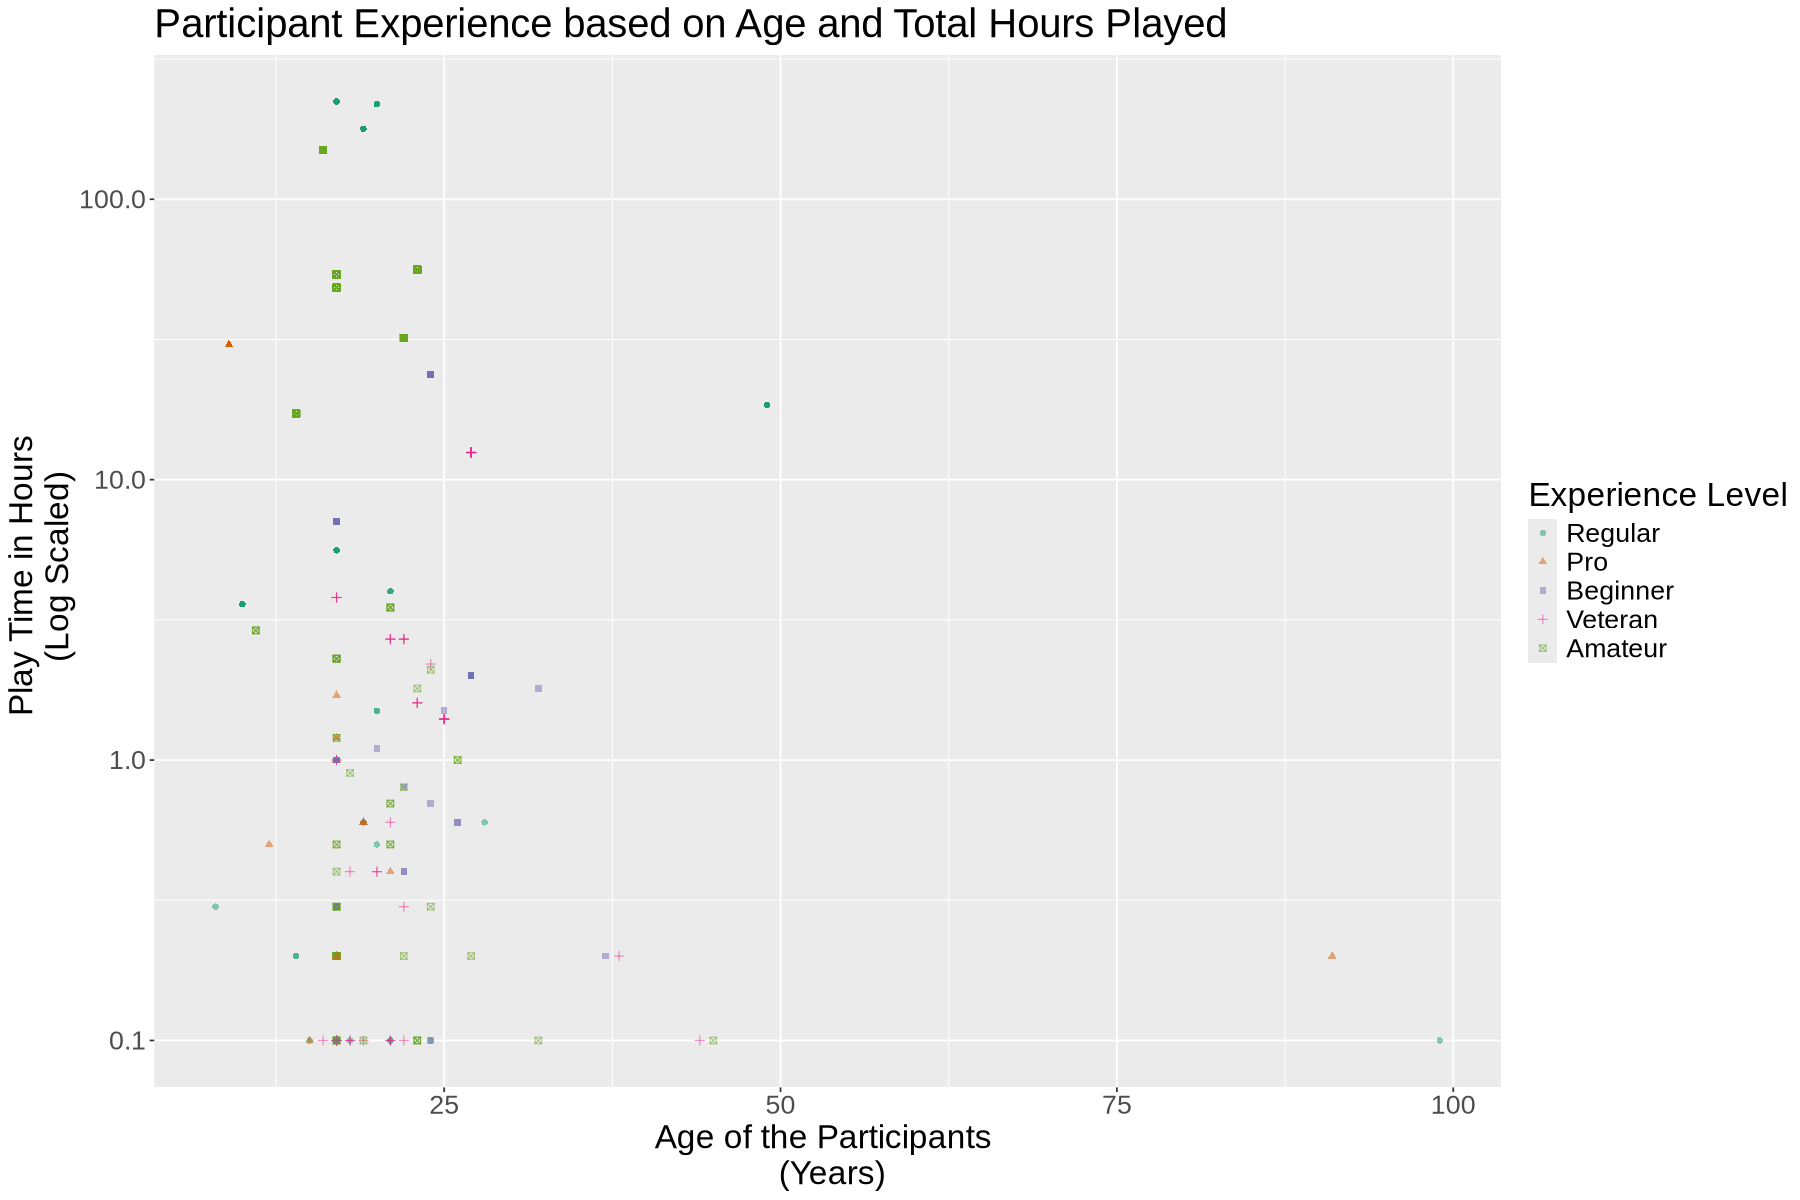

In [7]:
set.seed (100)

#Setting the initial plot size. (1)
options (repr.plot.width = 15, repr.plot.height = 10)

#Converting experience into a factor data type - categorical. (2)
playdate_final <- playdate_NA |>
select (experience:age) |>
mutate (experience = as_factor(experience))

#Creating a visualization to see what we're working with; x = age as it is independent, y = played_hours as it might change based on age. (3)
playdate_vision <- playdate_final |>
ggplot (aes(x = age, y = played_hours, color = experience, shape = experience)) +
geom_point(alpha = 0.5) +
scale_color_brewer (palette = "Dark2") +
labs (x = "Age of the Participants \n (Years)", y = "Play Time in Hours \n (Log Scaled)", title = "Participant Experience based on Age and Total Hours Played"
      , color = "Experience Level", shape = "Experience Level") +
theme (text = element_text (size = 20)) +
scale_y_log10 ()

#Creating the summary for total observations per class/category. (4)
playdate_summary <- playdate_final |>
group_by (experience) |>
summarise (total = n())

playdate_vision
playdate_summary

### Tuning the Model
This section focuses on tuning the model. We will use 5-fold cross-validation to select the best possible K value and create the most accurate model using the selected predictor variables. 

1. First, using **playdate_final**, we split the dataset with the ```initial_split``` function, allocating 75% to the training set and 25% to the testing set. The ```strata``` argument was set to our categorical variable, ```experience``` such that each split contained equal proportions of observations per category.

2. Next, we used the ```training``` and ```testing``` functions to obtain the splits in separate data frames, naming the two data frames **playdate_training** and **playdate_testing**.

3. Using the ```recipe``` function, we created a recipe to define the preprocessing steps to be applied to the data in the ```workflow``` function. Standardization is performed on the variables in the dataset specified by the **data** argument.

4. We created the KNN classifier using the ```nearest_neighbors``` function, setting ```weight_func``` to "rectangular" (one vote per neighbor). We set the ```neighbors``` argument to ```tune()``` to perform 5-fold cross-validation for the optimal K value. Finally, we set the engine to "kknn" and the mode to "classification".

5. Using the ```tibble``` function, we created a **K-values** data frame called **play_k**. We will test K values starting from **1** to **100**, stepping by **2** each time.

6. Next, we split the training set into **validation** and **training** subsets using the ```vfold_cv``` function, creating 5 evenly sized chunks and using one as the validation set each time, the rest being the training set. K-NN classification is done for each value per one of the 5 chunks, averaging the accuracies. This allows us to select the best **K parameter** based on the **highest** average accuracy.

7. Finally, we use the ```workflow``` function to build and tune the model. We then use the ```collect_metrics``` function and ```filter``` for **accuracies** for each **K-value** tested, arranging them in **descending** order. 

In [9]:
set.seed (100)

#Split the data into a training and testing set. (1)
playdate_split <- playdate_final |>
initial_split (prop = 0.75, strata = experience)

#Obtain the training and testing sets. (2) 
playdate_training <- training (playdate_split)
playdate_testing <- testing (playdate_split)

#Creating the recipe. (3)
playdate_recipe <- recipe (experience ~., data = playdate_training) |>
                    step_scale (all_predictors()) |>
                    step_center (all_predictors()) |>
                    step_upsample (experience, over_ratio = 1, skip = TRUE)
#Note: We set skip = TRUE to apply upsampling only to the training set and not the validation set for each instance of cross-validation. 


#Creating the tuning model. (4)
playdate_model_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
                        set_engine ("kknn") |>
                        set_mode ("classification")


#Creating the tibble of K values. (5)
play_k <- tibble (neighbors = seq (from = 1, to = 100, by = 2))


#Creating the validation data set (6)
playdate_vfold <- vfold_cv (playdate_training, v = 5, strata = experience)


#Creating the workflow and obtaining a data frame only containing the tested K-value accuracies. (7)
knn_tune_results <- workflow () |>
add_model (playdate_model_tune) |>
add_recipe (playdate_recipe) |>
tune_grid (resamples = playdate_vfold, grid = play_k) |>
collect_metrics () |>
filter (.metric == "accuracy") |>
arrange (desc(mean)) 

knn_tune_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9438626,5,0.002539993,Preprocessor1_Model01
3,accuracy,multiclass,0.9377106,5,0.002213546,Preprocessor1_Model02
5,accuracy,multiclass,0.9368373,5,0.002271259,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,accuracy,multiclass,0.8509174,5,0.02402749,Preprocessor1_Model50
97,accuracy,multiclass,0.8500441,5,0.02347594,Preprocessor1_Model49


From this, we see that **K = 1** achieves the highest **accuracy** when predicting classes (```experience```). However, we cannot select K = 1 as our parameter as it would lead to **overfitting**, causing the classifier to predict classes solely on the **closest neighbor**. This is undesirable, as simply changing the training set with another proportion of the data set would most likely lead to a **different class prediction**. Therefore, we will test both **K = 3** and **K = 5** to determine whether they are the next best parameters, and to assess whether there is **overfitting**. 

### Testing the K-Parameters (3 and 5) 
This section is quite similar to the previous one. As such, the narration of the code will occur in the code cell, and an analysis of the results will be provided in a markdown cell below.

In [64]:
set.seed (100)

#Splitting the training set into subsets - subtraining and subtesting
playdate_training_split <- initial_split (playdate_training, prop = 0.60, strata = experience)

#Obtaining the training and testing subsets
playdate_subtraining <- training (playdate_training_split)
playdate_subtesting <- testing (playdate_training_split)

#Creating the "sub" recipe
playdate_sub_recipe <- recipe (experience ~., data = playdate_subtraining) |>
                        step_scale (all_predictors()) |>
                        step_center (all_predictors()) |>
                        step_upsample (experience, over_ratio = 1, skip = TRUE)
                    #Using skip = TRUE only applies the oversampling to the training set

#Creating the "sub" model for 3 neighbors
playdate_sub_model_3 <- nearest_neighbor (weight_func = "rectangular", neighbors = 3) |>
                                        set_engine ("kknn") |>
                                        set_mode ("classification") 

#Creating the "sub" model for 5 neighbors. 
playdate_sub_model_5 <- nearest_neighbor (weight_func = "rectangular", neighbors = 5) |>
                                        set_engine ("kknn") |>
                                        set_mode ("classification") 

#Fitting the models into a workflow (for both models)
model_5_fit <- workflow () |>
                add_recipe (playdate_sub_recipe) |>
                add_model (playdate_sub_model_5) |>
                fit (data = playdate_subtraining)

model_3_fit <- workflow () |>
                add_recipe (playdate_sub_recipe) |>
                add_model (playdate_sub_model_3) |>
                fit (data = playdate_subtraining)

#Next, use the predict function to get predictions for each model on the subtesting data set
model_3_predicted <- predict (model_3_fit, playdate_subtesting) |>
                        bind_cols (playdate_subtesting)

model_5_predicted <- predict (model_5_fit, playdate_subtesting) |>
                        bind_cols (playdate_subtesting) 


#Finally, obtain the metrics (accuracy).
model_3_metrics <- model_3_predicted |>
                    metrics (truth = experience, estimate = .pred_class) |>
                    filter (.metric == "accuracy") |>
                    select (.estimate) 

model_5_metrics <- model_5_predicted |>
                    metrics (truth = experience, estimate = .pred_class) |>
                    filter (.metric == "accuracy") |>
                    select (.estimate) 

#We see that from model_3_metrics, we get an accuracy of 94.53%
model_3_metrics

#From model_5_metrics, we get an accuracy of 94.53%
model_5_metrics

.estimate
<dbl>
0.9452954


.estimate
<dbl>
0.9452954


Comparing the accuracies between the cross-validation split (K = 3: 93.77% and K = 5: 93.68%) and the subtraining split (K = 3: 94.53% and K = 5: 94.53%), we observe little to no difference in accuracy. Typically, overfitting results in a significant change in performance when the training set is swapped. However, despite changing the proportions in the training set (80% in the validation and 60% in the subtraining), the accuracies and predictions remain almost the same, suggesting that both models are not overfitting and thus, not heavily influenced by the training data. 

### Creating the Final Model 
In this part, we create the final model using K = 5 as it showed the least change in accuracy despite swapping training sets (validation and subtraining). 

After creating the model, we used the ```predict``` function to determine its accuracy with the test set, which achieved a 92.39% accuracy. Although this accuracy is somewhat lower compared to the cross-validation and subtraining processes, it is not significantly bad as it barely varied. Given the question of this project, it is reasonable to use this model to predict the **kinds** of players contributing the most hours/data as players outside the classified experience levels may contribute significantly as well. 

In [72]:
set.seed (100)

#We will be using the same recipe from "Tuning the Model". Therefore, we do not need to make a new one ("playdate_recipe")


#Create a new model with K = 5
nearest_playdate <- nearest_neighbor (weight_func = "rectangular", neighbors = 5) |>
                                        set_engine ("kknn") |>
                                        set_mode ("classification") 

#Create the workflow and fit the model onto playdate_training
playdate_final_fit <- workflow() |>
                    add_recipe (playdate_recipe) |>
                    add_model (nearest_playdate) |>
                    fit (data = playdate_training) 


#Finally, predict the testing set using the model and obtain the accuracy. 
playdate_final_predict <- predict (playdate_final_fit, playdate_testing) |>
                            bind_cols (playdate_testing) 

playdate_final_accuracy <- playdate_final_predict |>
                            metrics (truth = experience, estimate = .pred_class) |>
                            filter (.metric == "accuracy") |>
                            select (.estimate) 

playdate_final_accuracy #In this model, we have a 92.39% accuracy of prediction, which is not entirely bad.

.estimate
<dbl>
0.9238845


### Predicting **Kinds** of Players based on a Hypothetical Data Set
In this final section, we will identify the "**kinds**" of players by creating a hypothetical dataset and defining what we consider to be **a lot of data, or play hours**. We will then run this dataset and see what classes the KNN classifier predicts. Since the researchers aim to gather **over 10,000 hours of data**, it is reasonable to assume that 20-50 hours per individual would be considered a significant amount. 

Therefore...

1. Using the ```tibble``` function, we created a data frame consisting of ages from 8-100 with ```played_hours``` between 20-50.
   
2. Fit the model using the whole data frame instead of the split model and create a recipe based on the whole dataset (```playdate_final```). 

In [84]:
#Creating the columns for the new tibble data frame. (1)
age <- c (8, 14, 23, 34, 46, 55, 68, 79, 84, 91, 100) 
played_hours <- c (45, 50, 28, 24, 35, 46, 34, 45, 36, 21, 20)

#Creating the data frame. (1)
hypo_people <- tibble (age, played_hours)

#Creating the recipe and fitting the model. (2)
final_recipe <- recipe (experience ~., data = playdate_final) |>
                step_scale (all_predictors()) |>
                step_center (all_predictors()) |>
                step_upsample (experience, over_ratio = 1, skip = TRUE)

final_model <- nearest_playdate

final_fit <- workflow() |>
            add_model (final_model) |>
            add_recipe (final_recipe) |>
            fit (data = playdate_final)

#Using the newly fit model and predicting the hypothetical peoples' experience level. (3)
hypo_predict <- predict (final_fit, hypo_people) |>
                bind_cols (hypo_people)

print (hypo_predict)

# A tibble: 11 × 3
   .pred_class   age played_hours
   <fct>       <dbl>        <dbl>
 1 Pro             8           45
 2 Amateur        14           50
 3 Amateur        23           28
 4 Beginner       34           24
 5 Regular        46           35
 6 Regular        55           46
 7 Regular        68           34
 8 Pro            79           45
 9 Pro            84           36
10 Pro            91           21
11 Pro           100           20


Therefore, based on the data, the researchers should recruit people who are considered **Pros** and **Regulars** as they tend to contribute the most data more often.

## Discussion

Further research could be done on how to identify or classify a player as one of the five types. For example, what makes a specific player a pro level? An amateur level?

## References